# SINDy-SHRED: Toy Data Example (Low-Level API)

This notebook demonstrates the detailed workflow of SINDy-SHRED on synthetic toy data.
For a simpler high-level interface, see `sindy-shred_functionalized.toy-data.v2_refactor.ipynb`.

**Toy Data:** Combines two dynamical systems:
1. **FitzHugh-Nagumo Model** (slow dynamics)
2. **Unforced Duffing Oscillator** (fast dynamics)

These are combined via orthogonal mixing to create multi-scale spatio-temporal data.

## 1. Setup and Imports

In [1]:
import copy
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
import scipy
import seaborn as sns
import torch
from scipy.integrate import solve_ivp
from sklearn.preprocessing import MinMaxScaler

# Local modules
import sindy
import sindy_shred_net
import plotting
from utils import get_device, TimeSeriesDataset

warnings.filterwarnings("ignore")

# Create results directory
RESULTS_DIR = "results/toy_data"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_DIR}")

/home/mars/sindy-shred/sindyshred/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


Results will be saved to: results/toy_data


In [2]:
# Plotting configuration
sns.set_context("paper")
sns.set_style("whitegrid")

pcolor_kwargs = {
    "vmin": -3,
    "vmax": 3,
    "cmap": "RdBu_r",
    "rasterized": True,
}

### Device and Seed Configuration

In [3]:
# Device selection
device = get_device()
print(f"Using device: {device}")

# Set seeds for reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed(SEED)

Using device: cuda


## 2. Data Generation

Generate synthetic spatio-temporal data from FitzHugh-Nagumo and Duffing oscillator systems.

In [4]:
def rhs_FNM(t, x, tau, a, b, Iext):
    """FitzHugh-Nagumo Model (slow dynamics)."""
    v, w = x
    vdot = v - (v**3) / 3 - w + Iext
    wdot = (1 / tau) * (v + a - b * w)
    return np.array([vdot, wdot])


def rhs_UFD(t, y, eta, epsilon, tau):
    """Unforced Duffing Oscillator (fast dynamics)."""
    p, q = y
    pdot = q
    qdot = (1 / tau) * (-2 * eta * q - p - epsilon * p**3)
    return np.array([pdot, qdot])

In [5]:
# Time integration parameters
T = 64
dt_solve = 0.0001 * 8
t_solution = np.arange(0, T, dt_solve)

# FitzHugh-Nagumo parameters (slow mode, tau1=2)
x0 = np.array([-1.110, -0.125])
tau1 = 2
a = 0.7
b = 0.8
Iext = 0.65

# Duffing oscillator parameters (fast mode, tau2=0.2)
y0 = np.array([0, 1])
eta = 0
epsilon = 1
tau2 = 0.2

# Solve the ODEs
solution_fn = solve_ivp(
    rhs_FNM, [0, T], x0, t_eval=t_solution, args=(tau1, a, b, Iext)
)
solution_ufd = solve_ivp(
    rhs_UFD, [0, T], y0, t_eval=t_solution, args=(eta, epsilon, tau2)
)

print(f"FitzHugh-Nagumo solution shape: {solution_fn.y.shape}")
print(f"Duffing oscillator solution shape: {solution_ufd.y.shape}")

FitzHugh-Nagumo solution shape: (2, 80000)
Duffing oscillator solution shape: (2, 80000)


In [6]:
# Create mixed spatio-temporal data
seed = 1
num_space_dims = 10

# Tile the solutions to create spatial replicates
uv_tiled = np.hstack([
    np.tile(solution_fn.y.T, num_space_dims),
    np.tile(solution_ufd.y.T, num_space_dims),
])

# Subsample for computational efficiency
substep = 50
uv_tiled = uv_tiled[0::substep, :]
t_solution = t_solution[0::substep]
time = t_solution
dt_data = time[1] - time[0]

# Get dimensions
n_space_dims = uv_tiled.shape[1]
n_time = uv_tiled.shape[0]

# Apply orthogonal mixing
Q = scipy.stats.ortho_group.rvs(n_space_dims, random_state=seed)
Q = Q[0:n_space_dims, :]
x = uv_tiled @ Q

# Final data matrix (space x time for visualization, time x space for processing)
data_original = x.T

# Extract slow and fast mode components for comparison
slow_modes = uv_tiled[:, 0:n_space_dims // 2] @ Q[0:n_space_dims // 2, :]
fast_modes = uv_tiled[:, n_space_dims // 2:] @ Q[n_space_dims // 2:, :]

print(f"Data shape (space x time): {data_original.shape}")
print(f"Time step: {dt_data:.6f}")
print(f"Number of time samples: {n_time}")
print(f"Spatial dimension: {n_space_dims}")

Data shape (space x time): (40, 1600)
Time step: 0.040000
Number of time samples: 1600
Spatial dimension: 40


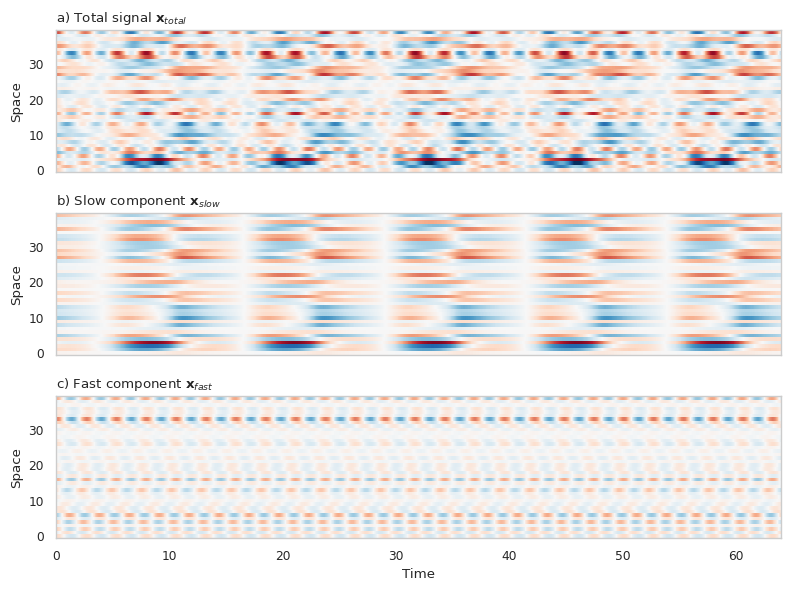

In [7]:
# Visualize generated data
space_dim = np.arange(n_space_dims)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(time, space_dim, data_original, **pcolor_kwargs)
ax.set_title(r"a) Total signal $\mathbf{x}_{total}$", loc="left")
ax.set_ylabel("Space")

ax = axes[1]
ax.pcolormesh(time, space_dim, slow_modes.T, **pcolor_kwargs)
ax.set_title(r"b) Slow component $\mathbf{x}_{slow}$", loc="left")
ax.set_ylabel("Space")

ax = axes[2]
ax.pcolormesh(time, space_dim, fast_modes.T, **pcolor_kwargs)
ax.set_title(r"c) Fast component $\mathbf{x}_{fast}$", loc="left")
ax.set_ylabel("Space")
ax.set_xlabel("Time")

fig.tight_layout()
fig.savefig(f"{RESULTS_DIR}/data_components.pdf", bbox_inches="tight", dpi=300)
plt.show()

## 3. Configuration and Data Preprocessing

In [8]:
# Sensor configuration (fixed for reproducibility)
sensor_locations = np.array([10, 28, 14, 11, 23, 27])
num_sensors = len(sensor_locations)

# Model hyperparameters
latent_dim = 4
poly_order = 1
include_sine = False

# Calculate library dimension
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, include_constant=True)

# Data split configuration
lags = 120
train_length = 750 // 4
validate_length = 0

# Prepare data (transpose to time x space, subsample)
load_X = copy.deepcopy(data_original)
load_X = load_X.T[::4]  # Subsample by 4
dt = dt_data * 4
lags = lags // 4

n = load_X.shape[0]
m = load_X.shape[1]

# SINDy threshold
sindy_threshold = 0.0

print(f"Data shape after preprocessing: {load_X.shape}")
print(f"Number of sensors: {num_sensors}")
print(f"Latent dimension: {latent_dim}")
print(f"Library dimension: {library_dim}")
print(f"Trajectory length (lags): {lags}")
print(f"Training length: {train_length}")
print(f"Time step: {dt:.6f}")

Data shape after preprocessing: (400, 40)
Number of sensors: 6
Latent dimension: 4
Library dimension: 5
Trajectory length (lags): 30
Training length: 187
Time step: 0.160000


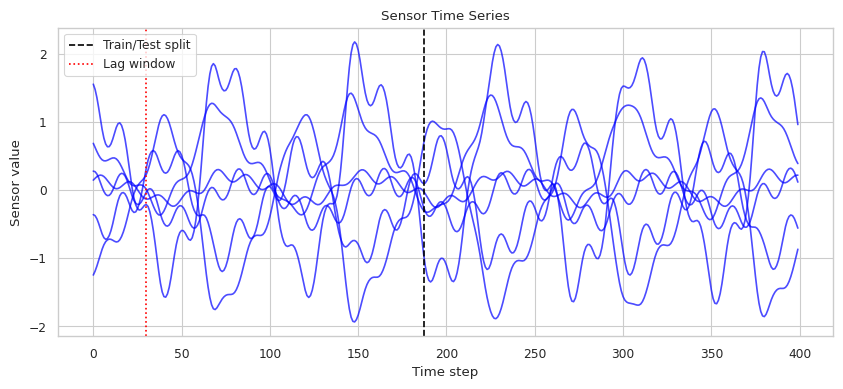

In [9]:
# Visualize sensor time series
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(load_X[:, sensor_locations], color='b', alpha=0.7)
ax.axvline(train_length, color='k', linestyle='--', label='Train/Test split')
ax.axvline(lags, color='r', linestyle=':', label='Lag window')
ax.set_xlabel('Time step')
ax.set_ylabel('Sensor value')
ax.set_title('Sensor Time Series')
ax.legend()
plt.show()

In [10]:
# Create train/test indices
train_indices = np.arange(0, train_length)

mask = np.ones(n - lags)
mask[train_indices] = 0
test_indices = np.arange(0, n - lags)[np.where(mask != 0)[0]]

# For this example, validation = empty
valid_indices = test_indices[:validate_length] if validate_length > 0 else train_indices[:1]

print(f"Train samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

Train samples: 187
Test samples: 183


In [11]:
# Scale data using MinMaxScaler
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

# Generate input sequences (sensor trajectories)
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

# Create input/output tensors
train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

# Create datasets
train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 187
Test dataset size: 183


## 4. Model Creation and Training

In [12]:
# Create SINDy-SHRED network
shred = sindy_shred_net.SINDy_SHRED_net(
    input_size=num_sensors,
    output_size=m,
    hidden_size=latent_dim,
    hidden_layers=2,
    l1=350,
    l2=400,
    dropout=0.1,
    library_dim=library_dim,
    poly_order=poly_order,
    include_sine=include_sine,
    dt=dt,
).to(device)

print("SINDy-SHRED network created")
print(f"Total parameters: {sum(p.numel() for p in shred.parameters())}")

SINDy-SHRED network created
Total parameters: 158554


In [13]:
# Train the model
validation_errors = sindy_shred_net.fit(
    shred,
    train_dataset,
    valid_dataset,
    batch_size=64,
    num_epochs=200,
    lr=1e-3,
    verbose=True,
    threshold=0.05,
    patience=5,
    sindy_regularization=10.0,
    optimizer="AdamW",
    thres_epoch=100,
)

1 : tensor(0.2336, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0350, device='cuda:

## 5. Evaluation

In [14]:
# Compute test reconstruction error
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())

relative_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
print(f"Test set relative reconstruction error: {relative_error:.4f}")

Test set relative reconstruction error: 0.1768


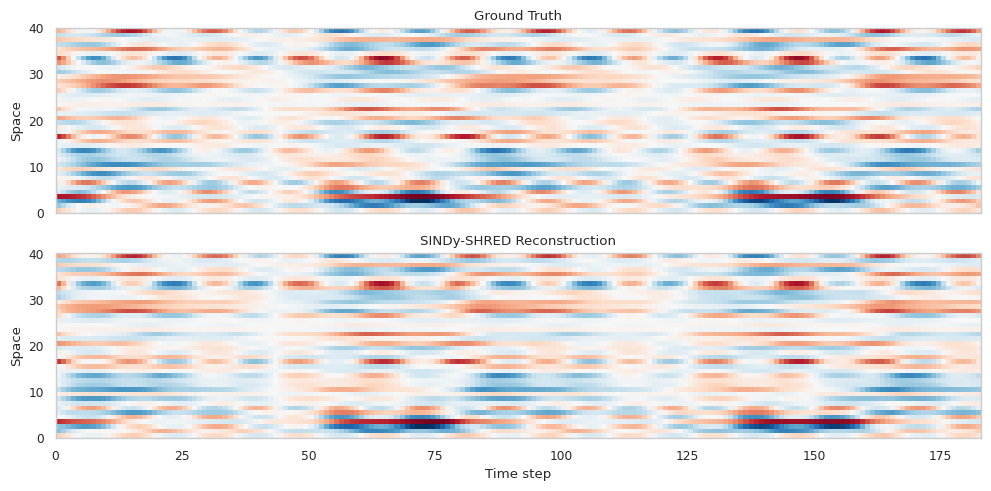

In [15]:
# Visualize reconstruction
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

ax = axes[0]
ax.pcolormesh(test_ground_truth.T, **pcolor_kwargs)
ax.set_title("Ground Truth")
ax.set_ylabel("Space")

ax = axes[1]
ax.pcolormesh(test_recons.T, **pcolor_kwargs)
ax.set_title("SINDy-SHRED Reconstruction")
ax.set_ylabel("Space")
ax.set_xlabel("Time step")

fig.tight_layout()
fig.savefig(f"{RESULTS_DIR}/reconstruction_comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()

## 6. Post-hoc SINDy Discovery

Extract latent trajectories and discover sparse governing equations.

In [16]:
# Extract latent trajectories from training data
gru_outs_train, _ = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs_train = gru_outs_train[:, 0, :]

# Normalize latent trajectories to [-1, 1]
gru_outs_normalized = gru_outs_train.clone()
for i in range(latent_dim):
    gru_outs_normalized[:, i] = (gru_outs_train[:, i] - torch.min(gru_outs_train[:, i])) / \
                                 (torch.max(gru_outs_train[:, i]) - torch.min(gru_outs_train[:, i]))
gru_outs_normalized = 2 * gru_outs_normalized - 1

x_train = gru_outs_normalized.detach().cpu().numpy()
gru_outs_train_np = gru_outs_train.detach().cpu().numpy()
print(f"Latent trajectories shape: {x_train.shape}")

Latent trajectories shape: (186, 4)


In [17]:
# SINDy discovery
differentiation_method = ps.differentiation.FiniteDifference()

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=sindy_threshold, alpha=0.05),
    differentiation_method=differentiation_method,
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)

model.fit(x_train, t=dt)
print("\nDiscovered SINDy equations:")
model.print()


Discovered SINDy equations:
(x0)' = -0.031 1 + 1.776 x0 + 2.517 x1 + 2.462 x2 + 0.003 x3
(x1)' = 0.024 1 + -0.898 x0 + -1.539 x1 + -1.102 x2 + 0.730 x3
(x2)' = -0.044 1 + -1.670 x0 + 0.072 x1 + -1.133 x2 + -1.966 x3
(x3)' = -0.033 1 + 1.136 x0 + 0.403 x1 + 1.609 x2 + 0.933 x3


### True Governing Equations

**Slow modes (FitzHugh-Nagumo):**
$$\dot{v} = v - \frac{1}{3}v^3 - w + 0.65$$
$$\dot{w} = \frac{1}{\tau_1}(v + 0.7 - 0.8w)$$
with $\tau_1 = 2$.

**Fast modes (Duffing):**
$$\dot{p} = q$$
$$\dot{q} = -\frac{1}{\tau_2}(p + p^3)$$
with $\tau_2 = 0.2$.

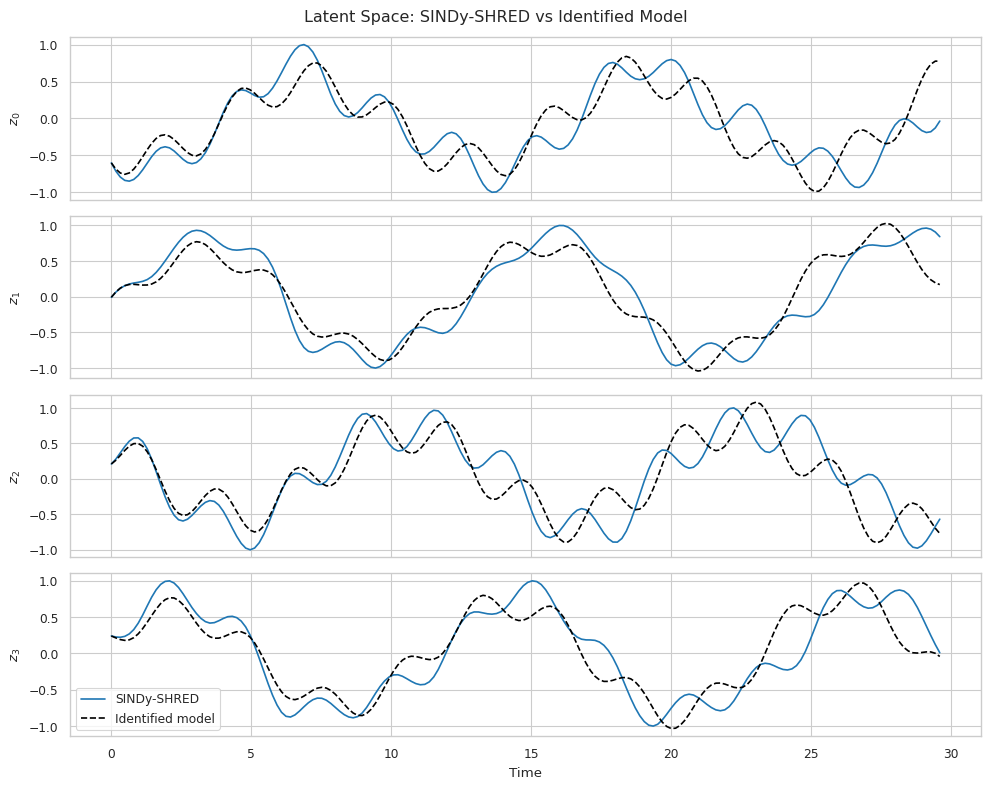

In [18]:
# Simulate discovered model
t_sim = np.arange(0, len(x_train) * dt, dt)
init_cond = x_train[0, :]
x_sim = model.simulate(init_cond, t_sim)

# Plot comparison
fig, axes = plt.subplots(latent_dim, 1, figsize=(10, 2 * latent_dim), sharex=True)
for i in range(latent_dim):
    axes[i].plot(t_sim, x_train[:len(t_sim), i], label="SINDy-SHRED")
    axes[i].plot(t_sim, x_sim[:, i], "k--", label="Identified model")
    axes[i].set_ylabel(rf"$z_{{{i}}}$")
    if i == latent_dim - 1:
        axes[i].set_xlabel("Time")
        axes[i].legend()

fig.suptitle("Latent Space: SINDy-SHRED vs Identified Model")
fig.tight_layout()
fig.savefig(f"{RESULTS_DIR}/latent_comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()

## 7. Sensor-Level Predictions

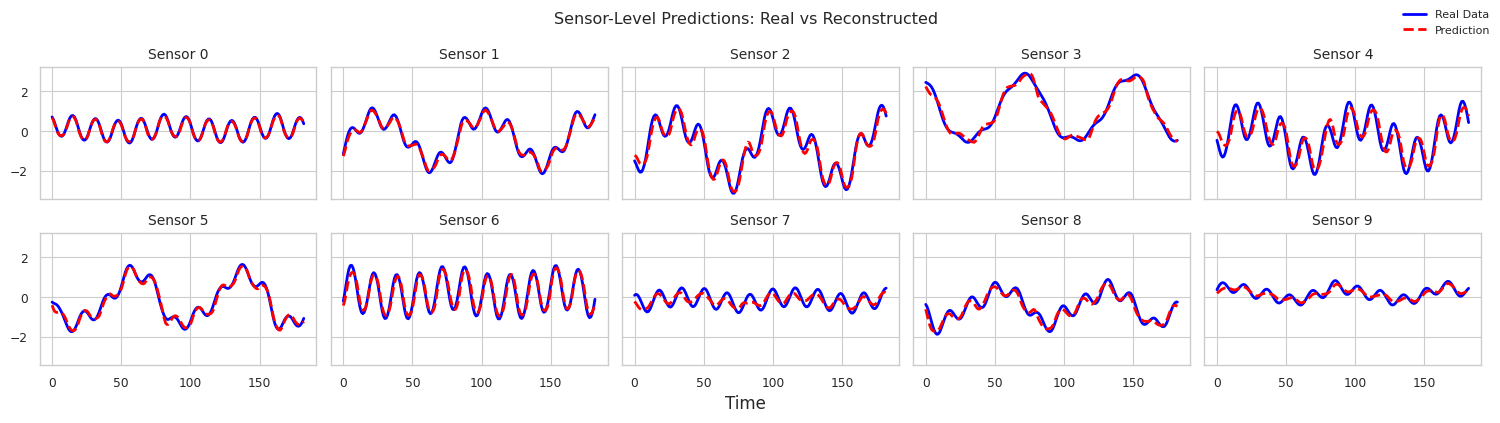

In [19]:
# Plot sensor-level comparisons (all spatial dimensions)
fig, axes = plotting.plot_sensor_predictions(
    test_ground_truth,
    test_recons,
    sensor_locations=np.arange(n_space_dims),
    rows=2,
    cols=5,
    save_path=f"{RESULTS_DIR}/sensor_predictions_grid.pdf"
)
fig.suptitle("Sensor-Level Predictions: Real vs Reconstructed")
fig.tight_layout()
plt.show()

## 8. Save Results

In [20]:
# Save trained model
torch.save(shred.state_dict(), f"{RESULTS_DIR}/shred_model.pt")
print(f"Saved SHRED model to {RESULTS_DIR}/shred_model.pt")

# Save latent trajectories
np.save(f"{RESULTS_DIR}/latent_train.npy", x_train)
print(f"Saved latent trajectories")

# Save SINDy coefficients
sindy_coefficients = model.coefficients()
np.save(f"{RESULTS_DIR}/sindy_coefficients.npy", sindy_coefficients)
print(f"Saved SINDy coefficients: shape {sindy_coefficients.shape}")

# Save feature names
feature_names = model.get_feature_names()
with open(f"{RESULTS_DIR}/sindy_feature_names.txt", "w") as f:
    for name in feature_names:
        f.write(name + "\n")

# Save original data
np.save(f"{RESULTS_DIR}/data_original.npy", data_original)
np.save(f"{RESULTS_DIR}/slow_modes.npy", slow_modes)
np.save(f"{RESULTS_DIR}/fast_modes.npy", fast_modes)

# Save config
config = {
    "latent_dim": latent_dim,
    "poly_order": poly_order,
    "num_sensors": num_sensors,
    "lags": lags,
    "train_length": train_length,
    "dt": dt,
    "sindy_threshold": sindy_threshold,
    "relative_error": relative_error,
}
np.save(f"{RESULTS_DIR}/config.npy", config)

print("\nAll results saved!")

Saved SHRED model to results/toy_data/shred_model.pt
Saved latent trajectories
Saved SINDy coefficients: shape (4, 5)

All results saved!
